# Bistatic RCS generated by dielectric spheres

<i>Note that the following notebook is very compute intensive. To speed it up disable the near-field computations.</i>

In this notebook, we consider the bistatic radar cross section generated from plane wave scattering by an array of dielectric spheres $\Omega_j$, each with its individual permittivity $\epsilon_j$ and permeability $\mu_j$.

We denote by $\epsilon_{0}$ and $\mu_0$ the electric permittivity and magnetic permeability in vacuum, and by $\epsilon_{r, j} = \frac{\epsilon_j}{\epsilon_0}$ and $\mu_{r, j} = \frac{\mu_j}{\mu_0}$ the relative permittivity and relative permeability for each dielectric object. Denote by $\mathbf{E}^\text{s}$, $\mathbf{H}^\text{s}$ the scattered electric and magnetic field in the exterior of the scatterers. Moreover, let $\mathbf{E}$ and $\mathbf{H}$ be the total exterior fields. Correspondingly, we denote the interior fields in the $j$th obstacle by $\mathbf{E}_j$ and $\mathbf{H}_j$.

For a given medium, we normalize the Maxwell equations by setting $\hat{\mathbf{H}} = \sqrt{\mu}\mathbf{H}$ and $\hat{\mathbf{E}} = \sqrt{\epsilon}\mathbf{E}$ and obtain

\begin{align}
\nabla\times \hat{\mathbf{E}} &= \mathrm{i}k \hat{\mathbf{H}},\nonumber\\
\nabla\times \mathbf{H} &= -\mathrm{i}k \mathbf{E}.\nonumber
\end{align}
with $k=\omega\sqrt{\mu\epsilon}$.

The electric field equations for the dielectric scattering problem now take the form
\begin{align}
\nabla\times\nabla\times \hat{\mathbf{E}}^{s}(x) - k_0^2\hat{\mathbf{E}}^{s}(x) &= 0,~x\in\Omega^{+}\nonumber\\
\nabla\times\nabla \times \hat{\mathbf{E}}_{j}(x) - k_j^2\hat{\mathbf{E}}_{j}(x) &= 0,~x\in\Omega_j\nonumber\\
\end{align}
with $k_0 = \omega\sqrt{\epsilon_0\mu_0}$ and $k_j = k_0\sqrt{\epsilon_{r,j}\mu_{r,j}}$.

We still have to fix the correct boundary conditions between the media.

We denote the interior tangential trace of the electric field $\mathbf{E}_{j}$ at the $j$th obstacle as $\gamma_\text{t}^{j, -} \mathbf{E}_{j} = \mathbf{E}_{j}\times \nu$ with $\nu$ the exterior normal direction on the boundary of $\Omega_j$. Correspondingly, we define the exterior tangential trace $\gamma_\text{t}^{j, +}\mathbf{E} = \mathbf{E}\times \nu$. Moreover, we define the interior Neumann trace as $\gamma_\text{N}^{j,-} \mathbf{E}_{j} = \frac{1}{\mathrm{i}k_j}\gamma_\text{t}^{j,-}\left(\nabla\times \mathbf{E}_{j}\right)$ and the exterior Neumann trace as $\gamma_\text{N}^{j,+} \mathbf{E} = \frac{1}{\mathrm{i}k_0}\gamma_\text{t}^{j,+}\left(\nabla\times \mathbf{E}\right)$.

The boundary conditions on the $j$th obstacles are that the tangential component of the electric and magnetic field is continuous across the boundary. Taking the rescaling into account this implies the conditions
\begin{align}
\gamma_\text{t}^{j, -}\hat{\mathbf{E}}_j &= \sqrt{\epsilon_{r,j}}\gamma_\text{t}^{j,+}\hat{\mathbf{E}}\nonumber\\
\gamma_\text{N}^{j, -}\hat{\mathbf{E}}_j &= \sqrt{\mu_{r,j}}\gamma_\text{N}^{j,+}\hat{\mathbf{E}}.
\end{align}
Towards infinity we need to satisfy the Silver-M&uuml;ller radiation conditions, which are given as
$$
\lim_{|\mathbf{x}|\rightarrow\infty}|\mathbf{x}|\left(\hat{\mathbf{H}}^\text{s}(\mathbf{x})\times \frac{x}{|x|} - \hat{\mathbf{E}}^\text{s}(\mathbf{x})\right) = 0
$$
uniformly in all directions.

In the following we describe a formulation based on the multitrace operator $\mathsf{A}:=\begin{bmatrix}\mathsf{H} & \mathsf{E}\\ - \mathsf{E} & \mathsf{H}\end{bmatrix}$ whose implementation in Bempp is described in more detail in [Scroggs, Betcke, Smigaj (2017)](https://bempp.com/publications/#scroggs). Here, the operator $\mathsf{H}$ is the magnetic boundary operator and $\mathsf{E}$ is the electric boundary operator. The operator $\mathsf{A}_{j,+}$ associated with the exterior solution on the boundary of $\Omega_j$ satisfies
$$
\left[\frac{1}{2}\mathsf{Id} - \mathsf{A}_{j,+}\right]\begin{bmatrix}\gamma_\text{t}^{j,+}{\hat{\mathbf{E}}^\text{s}}\\ \gamma_\text{N}^{j,+}{\hat{\mathbf{E}}^\text{s}}\end{bmatrix} = 
\begin{bmatrix}\gamma_\text{t}^{j,+}{\hat{\mathbf{E}}^\text{s}}\\ \gamma_\text{N}^{j,+}{\hat{\mathbf{E}}^\text{s}}\end{bmatrix},
$$
where $\mathsf{A}_{j,+}$ is the multitrace operator on the boundary of $\Omega_j$ with wavenumber $k_0$. The interior solutions $\mathbf{E}^{j}$ satisfy
$$
\left[\frac{1}{2}\mathsf{Id} + \mathsf{A}_{j,-}\right]\begin{bmatrix}\gamma_\text{t}^{j,-}{\hat{\mathbf{E}}_j}\\ \gamma_\text{N}^{j,-}{\hat{\mathbf{E}}_j}\end{bmatrix} = 
\begin{bmatrix}\gamma_\text{t}^{j,-}{\hat{\mathbf{E}}_j}\\ \gamma_\text{N}^{j,-}\hat{\mathbf{E}}_j\end{bmatrix},
$$
where $\mathsf{A}_{j,-}$ is the multitrace operator across the boundary of $\Omega_j$ with wavenumber $k_j$. 

Now denote by $\hat{V}_j^\text{s}:=\begin{bmatrix}\gamma_\text{t}^{j,+}\hat{\mathbf{E}}^{s}\\ \gamma_\text{N}^{j,+}\hat{\mathbf{E}}^\text{s}\end{bmatrix}$ the vector of trace data associated with the scattered field on the boundary of $\Omega_j$. Correspondingly, we denote by $\hat{V}_j$ the vector of the trace data of the interior solution in $\Omega_j$ and by $\hat{V}^\text{inc}$ the vector of trace data of the incident field on the boundary of $\Omega_j$.

We first consider the case of a single scatterer $\Omega_1$. The boundary conditions are given by
$$
\hat{V}_1 = \begin{bmatrix}\sqrt{\epsilon_{r, 1}} & \\ & \sqrt{\mu_{r, 1}}\end{bmatrix}\left(\hat{V}_1^\text{s} + \hat{V}_1^\text{inc}\right)=: D_1\left(\hat{V}_1^\text{s} + \hat{V}_1^\text{inc}\right).
$$
From $\left(\frac{1}{2}\mathsf{Id} + \mathsf{A}_{1,-}\right)\hat{V}_1 = \hat{V}_1$ together with the above relationship for the exterior multitrace operator, and the boundary condition, we obtain that
$$
\left(\frac{1}{2}\mathsf{Id} + \mathsf{A}_{1,-}\right)D_1\left(\hat{V}_1^\text{s} + \hat{V}_1^\text{inc}\right) = D_1\left(\frac{1}{2}\mathsf{Id} - \mathsf{A}_{1,+}\right)\hat{V}_1^\text{s} + D_1\hat{V}_1^\text{inc}.
$$
Simplifying the above equation leads to
$$
\left(D_1^{-1}\mathsf{A}_{1,-}\mathsf{D}_1 + \mathsf{A}_{1, +}\right)\hat{V}_1^\text{s} = \left(\frac{1}{2}\mathsf{Id} - D_1^{-1}\mathsf{A}_{1, -}D_1\right)\hat{V}^\text{inc}.
$$
Now assume that we have a whole array of scatterers. Then the equation for each scatterer becomes
$$
\left(D_j^{-1}\mathsf{A}_{j,-}D_j + \mathsf{A}_{j, +}\right)\hat{V}_j^\text{s} = \left(\frac{1}{2}\mathsf{Id} - D_j^{-1}\mathsf{A}_{j, -}D_j\right)\hat{V}^\text{inc} - \sum_{i\neq j}\mathsf{A}_{i,j}\hat{V}_i^\text{s}
$$
for each scatterer $j$. The operator $-\mathsf{A}_{i, j}$ maps scattered trace data on the $j$th scatterer to exterior trace data on the $i$th scatterer. It is just the exterior Stratton-Chu formula, hence the minus sign. To implement $\mathsf{A}_{i, j}$ one just implements the multitrace operator with domain space on one obstacle and test space on the other obstacle.

If there are $N$ obstacles then the above formula leads to a block operator system with $2N$ equations in $2N$ unknowns, whch is fully determined. In the following we demonstrate the implementation of this system in Bempp.

We start with the usual imports and enable console logging.

In [1]:
import bempp.api
import numpy as np

bempp.api.enable_console_logging()
bempp.api.pool.create_device_pool("AMD")

bempp:HOST:INFO: Creating pool for Platform: AMD Accelerated Parallel Processing
bempp:HOST:INFO: Created pool with 2 workers.


For this notebook we will use three spheres of radius 0.4, centered at $-1$, $0$, and $1$ on the x-axis.

In [2]:
centers = [-1, 0, 1]

radius = .4

number_of_scatterers = len(centers)

grids = [bempp.api.shapes.sphere(r=radius, origin=(c, 0, 0), h=0.1)
        for c in centers]

bempp:HOST:INFO: Created grid with id f77f25a6-74f7-4424-9904-8615c88b367c. Elements: 638. Edges: 957. Vertices: 321
bempp:HOST:INFO: Created grid with id a953552d-c0d3-4559-aaf5-6ce41ad2af98. Elements: 652. Edges: 978. Vertices: 328
bempp:HOST:INFO: Created grid with id 6fee21ee-62cf-44c5-a3a6-1a047c5375f7. Elements: 640. Edges: 960. Vertices: 322


We now define the associated constants and material parameters. We have chosen the material parameters for Teflon. The overall simulation will be running at a frequency of 300Mhz.

In [3]:
frequency = 300E6 # 300Mhz

vacuum_permittivity = 8.854187817E-12
vacuum_permeability = 4 * np.pi * 1E-7

rel_permittivities = number_of_scatterers * [2.1]
rel_permeabilities = number_of_scatterers * [1.0]

k0 = 2 * np.pi * frequency * np.sqrt(vacuum_permittivity * vacuum_permeability)
wavenumbers = [k0 * np.sqrt(er * mr) for er, mr in zip(rel_permittivities, rel_permeabilities)]
print("The exterior wavenumber is: {0}".format(k0))
print("The interior wavenumbers are:")
print(wavenumbers)

The exterior wavenumber is: 6.287535065634769
The interior wavenumbers are:
[9.111503944099038, 9.111503944099038, 9.111503944099038]


We now assemble the incident wave field. To that affect we choose a z-polarized plane wave travelling at an inciden angle theta in the (x,y) plane. Note that we already scale it with $\sqrt{\epsilon_0}$ to obtain the field $\hat{\mathbf{E}}^\text{inc}$.

In [4]:
theta = np.pi / 4 # Incident wave travelling at a 45 degree angle
direction = np.array([np.cos(theta), np.sin(theta), 0])
polarization = np.array([0, 0, 1.0])

def plane_wave(point):
    return polarization * np.exp(1j * k0 * np.dot(point, direction))

def scaled_plane_wave(point):
    return np.sqrt(vacuum_permittivity) * plane_wave(point)

@bempp.api.complex_callable
def tangential_trace(point, n, domain_index, result):
    value = np.sqrt(vacuum_permittivity) * polarization * np.exp(1j * k0 * np.dot(point, direction))
    result[:] =  np.cross(value, n)

def scaled_plane_wave_curl(point):
    return np.cross(direction, polarization) * 1j * k0 * np.sqrt(vacuum_permittivity) * np.exp(1j * k0 * np.dot(point, direction))

@bempp.api.complex_callable
def neumann_trace(point, n, domain_index, result):
    value = np.cross(direction, polarization) * 1j * k0 * np.sqrt(vacuum_permittivity) * np.exp(1j * k0 * np.dot(point, direction))
    result[:] =  1./ (1j * k0) * np.cross(value, n)


Before we setup the left-hand side block operator matrix we write a small routine that rescales a given $2\times 2$ block operator matrix $A$ to $D^{-1}AD$, where $D$ is a diagonal matrix defined by its diagonal elements $d_1$ and $d_2$.

In [5]:
def rescale(A, d1, d2):
    """Rescale the 2x2 block operator matrix A"""
    
    A[0, 1] = A[0, 1] * (d2 / d1)
    A[1, 0] = A[1, 0] * (d1 / d2)
    
    return A

We now create all the scaled interior multitrace operators and the non-scaled exterior multitrace operators.

In [6]:
scaled_interior_operators = [
    rescale(bempp.api.operators.boundary.maxwell.multitrace_operator(
        grid, wavenumber, space_type='electric_dual', assembler='dense_evaluator', precision='single'), 
            np.sqrt(epsr), np.sqrt(mur)) for grid, wavenumber, epsr, mur in
            zip(grids, wavenumbers, rel_permittivities, rel_permeabilities)
]

identity_operators = [
    bempp.api.operators.boundary.sparse.multitrace_identity(op)
    for op in scaled_interior_operators
]

exterior_operators = [
    bempp.api.operators.boundary.maxwell.multitrace_operator(
        grid, k0, space_type='electric_dual', assembler='dense_evaluator', precision='single') for grid in grids
]

bempp:HOST:INFO: Created grid with id 0634a55a-42b3-4a90-97ef-c1b4f534ca2d. Elements: 3828. Edges: 5742. Vertices: 1916
bempp:HOST:INFO: OpenCL Device set to: pthread-Intel(R) Xeon(R) W-2155 CPU @ 3.30GHz
bempp:HOST:INFO: Created grid with id 0ff6bd7b-9a70-4fe4-a3ef-d8622a939a42. Elements: 3912. Edges: 5868. Vertices: 1958
bempp:HOST:INFO: Created grid with id 4f2f7d91-d56b-4762-b8cb-33fb85d6e6ad. Elements: 3840. Edges: 5760. Vertices: 1922


We can now loop through the rows of the left-hand side block system to create all block operator entries. We will store the filter operators $\frac{1}{2}\mathsf{Id} - D_j^{-1}\mathsf{A}_{j, -}D_j$ and the transfer operators $\mathsf{A}_{i,j}$. The filter operators will be needed for the right-hand side, and the transfer operators will be needed to compute the interior near-field in each obstacle.

In [7]:
from bempp.api.assembly.blocked_operator import GeneralizedBlockedOperator

filter_operators = number_of_scatterers * [None]
transfer_operators = np.empty((number_of_scatterers, number_of_scatterers), dtype=np.object)

#The following will contain the left-hand side block operator
op = np.empty((number_of_scatterers, number_of_scatterers), dtype=np.object)

for i in range(number_of_scatterers):
    filter_operators[i] = .5 * identity_operators[i]- scaled_interior_operators[i]
    for j in range(number_of_scatterers):
        if i == j:
            # Create the diagonal elements
            op[i, j] = scaled_interior_operators[j] + exterior_operators[j]
        else:
            # Do the off-diagonal elements
            transfer_operators[i, j] = bempp.api.operators.boundary.maxwell.multitrace_operator(
                grids[j], k0, target=grids[i], space_type="electric_dual", assembler="dense_evaluator", precision='single')
            op[i, j] = transfer_operators[i, j]
blocked_operator = GeneralizedBlockedOperator(op)

The following code assembles the right-hand sides.

In [8]:
rhs = 2 * number_of_scatterers * [None]
incident_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    incident_trace_data[i] = (
        bempp.api.GridFunction(blocked_operator.domain_spaces[2 * i], fun=tangential_trace, dual_space=blocked_operator.dual_to_range_spaces[2 * i]),
        bempp.api.GridFunction(blocked_operator.domain_spaces[2 * i + 1], fun=neumann_trace, 
                               dual_space=blocked_operator.dual_to_range_spaces[2 * i + 1]))
    rhs[2 * i], rhs[2 * i + 1] = filter_operators[i] * incident_trace_data[i]

We now have everything in place to solve the resulting scattering problem. We use mass matrix preconditioning to precondition the system.

In [9]:
bempp.api.enable_console_logging()
sol, info, _ = bempp.api.linalg.gmres(blocked_operator, rhs, use_strong_form=True, return_residuals=True)

bempp:HOST:INFO: Starting GMRES iteration
bempp:HOST:INFO: GMRES Iteration 1 with residual 0.43583039705163845
bempp:HOST:INFO: GMRES Iteration 2 with residual 0.2755373752267419
bempp:HOST:INFO: GMRES Iteration 3 with residual 0.1383105356552037
bempp:HOST:INFO: GMRES Iteration 4 with residual 0.09826500580926656
bempp:HOST:INFO: GMRES Iteration 5 with residual 0.06240219348917185
bempp:HOST:INFO: GMRES Iteration 6 with residual 0.05606766660903622
bempp:HOST:INFO: GMRES Iteration 7 with residual 0.032865749172841976
bempp:HOST:INFO: GMRES Iteration 8 with residual 0.02152089331466054
bempp:HOST:INFO: GMRES Iteration 9 with residual 0.011508024941734456
bempp:HOST:INFO: GMRES Iteration 10 with residual 0.008568157553557483
bempp:HOST:INFO: GMRES Iteration 11 with residual 0.004277455935141667
bempp:HOST:INFO: GMRES Iteration 12 with residual 0.0026102296490043008
bempp:HOST:INFO: GMRES Iteration 13 with residual 0.0011855811398403151
bempp:HOST:INFO: GMRES Iteration 14 with residual 0

In the following we visualize the near-field. The above code has computed the exterior trace data. But we also want to visualize the interior solutions. So we have to compute the interior trace data as well, which is done in the following code.

In [10]:
interior_trace_data = number_of_scatterers * [None]

for i in range(number_of_scatterers):
    interior_trace_data[i] = [np.sqrt(rel_permittivities[i]) * incident_trace_data[i][0],
                              np.sqrt(rel_permeabilities[i]) * incident_trace_data[i][1]]
    interior_trace_data[i][0] += np.sqrt(rel_permittivities[i]) * sol[2 * i]
    interior_trace_data[i][1] += np.sqrt(rel_permeabilities[i]) * sol[2 * i + 1]    

We now create a grid of plotting points in the $(\mathbf{x},\mathbf{y})$ plane and assign the indices in the sets associated with one of the obstacles or the exterior.

In [11]:
# Number of points in the x-direction
nx = 200

# Number of points in the y-direction
ny = 200

# Generate the evaluation points with numpy
x, y, z = np.mgrid[-2:2:nx * 1j, -2:2:ny * 1j, 0:0:1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')
index_sets = number_of_scatterers * [None]

index = 0
for c in centers:
    shifted_points = points - np.array([[c, 0, 0]]).T
    found_indices = np.arange(points.shape[1], dtype='uint32')[
            np.sum(shifted_points**2, axis=0) < radius**2]
    all_indices[found_indices] = 0
    index_sets[index] = found_indices
    index += 1
ext_indices = np.arange(points.shape[1], dtype='uint32')[all_indices == 1]
int_indices = np.arange(points.shape[1], dtype='uint32')[all_indices == 0]

For each scatterer we now evaluate the interior and exterior potentials on the associated points.

In [12]:
exterior_values = np.zeros((3, len(ext_indices)), dtype='complex128')
interior_values = number_of_scatterers * [None]

ext_points = points[:, ext_indices]

for i in range(number_of_scatterers):
    int_points = points[:, index_sets[i]]
    epot_int = bempp.api.operators.potential.maxwell.electric_field(interior_trace_data[i][1].space, int_points,
                                                                    wavenumbers[i])
    mpot_int = bempp.api.operators.potential.maxwell.magnetic_field(interior_trace_data[i][0].space, int_points,
                                                                   wavenumbers[i])
    epot_ext = bempp.api.operators.potential.maxwell.electric_field(sol[2 * i + 1].space, ext_points, k0)
    mpot_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[2 * i].space, ext_points, k0)
    
    exterior_values += -epot_ext * sol[2 * i + 1] - mpot_ext * sol[2 * i]    
    interior_values[i] = (epot_int * interior_trace_data[i][1] + mpot_int * interior_trace_data[i][0])

The following code now plots the squared absolute value of the electric near field.

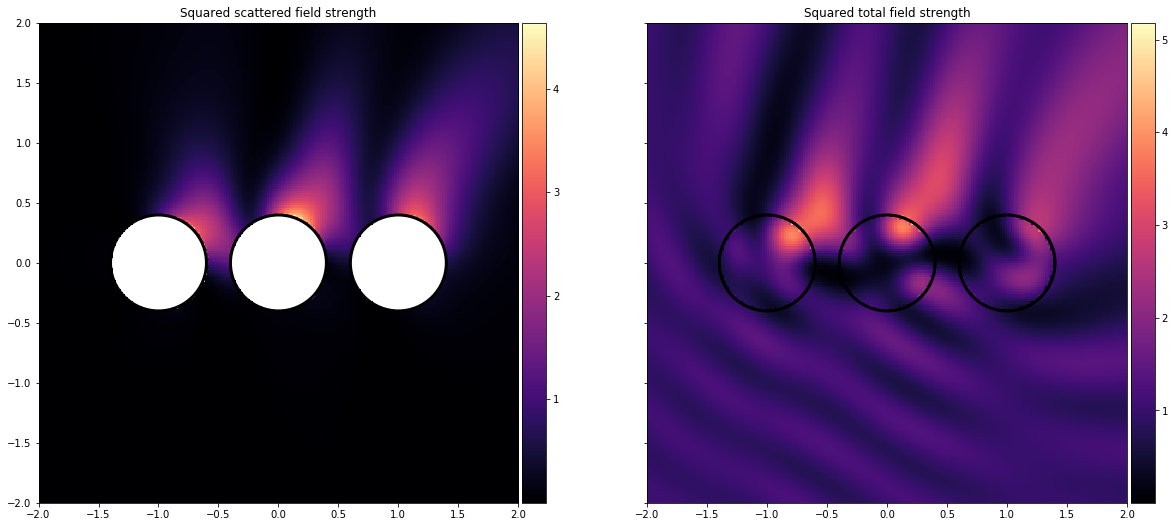

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = (20, 16) # Increase the figure size in the notebook

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, ext_indices] = 1./np.sqrt(vacuum_permittivity) * exterior_values

# Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for i in range(exterior_values.shape[1]):
    total_field[:, ext_indices[i]] = scattered_field[:, ext_indices[i]] + plane_wave(points[:, ext_indices[i]])
    
for i in range(number_of_scatterers):
    # Add interior contributions
    total_field[:, index_sets[i]] = 1. / np.sqrt(rel_permittivities[i] * vacuum_permittivity) * interior_values[i]
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, ny).T
total_image = squared_total_field.reshape(nx, ny).T
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

f0 = axes[0].imshow(scattered_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2])
for c in centers:
    axes[0].add_patch(
        Circle((c, 0), radius, facecolor='None', edgecolor='k', lw=3))
    
axes[0].set_title("Squared scattered field strength")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f0, cax=cax)

f1 = axes[1].imshow(total_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2])
for c in centers:
    axes[1].add_patch(
        Circle((c, 0), radius, facecolor='None', edgecolor='k', lw=3))

axes[1].set_title("Squared total field strength")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f1, cax=cax)

plt.show()


We now evaluate the bistatic radar cross section with the given incident angle. Here, we are only interested in backscattering into negative y plane. First, we define the evaluation points on the lower half of the unit circle. For the RCS we define the 0 degree angle to point into the negative x-direction, and correspondingly the 180 degree angle to be pointing into the positive x-direction.

In [14]:
number_of_angles = 400
angles = np.pi * np.linspace(0, 1, number_of_angles)
unit_points = np.array([-np.cos(angles), -np.sin(angles), np.zeros(number_of_angles)])

We now assemble for each scatterer the electric and magnetic far-field operators and evaluate the scattered field contribution for each of them. The assembly of the far-field operators will be done in dense mode as they are sufficiently small.

In [15]:
far_field = np.zeros((3, number_of_angles), dtype='complex128')

for i in range(number_of_scatterers):
    electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[2 * i + 1].space, unit_points, k0)
    magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[2 * i].space, unit_points, k0)    
    far_field += -electric_far * sol[2 * i + 1] - magnetic_far * sol[2 * i]
far_field *= 1./ np.sqrt(vacuum_permittivity)

We now have everything together to plot the bistatic RCS.

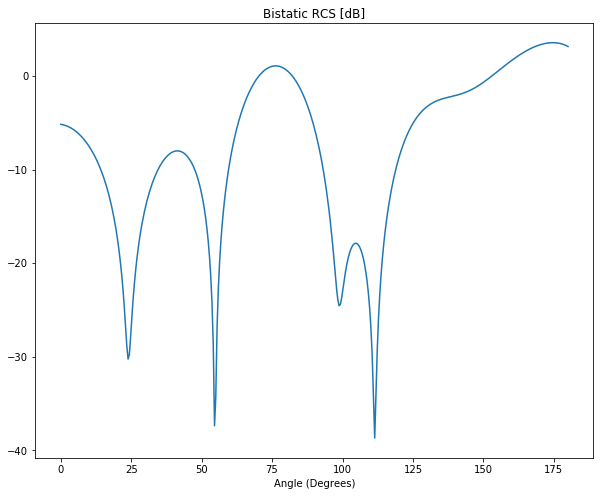

In [16]:
plt.rcParams['figure.figsize'] = (10, 8) # Resize the figure

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs)
plt.title("Bistatic RCS [dB]")
_ = plt.xlabel('Angle (Degrees)')